In [2]:
from wgan import WGAN
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()  # gp loss won't work with eager
from functools import partial
from NuRadioReco.utilities import fft
from NuRadioReco.utilities import units
from NuRadioReco.framework import base_trace
import sys
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("analyze.py"))))
sys.path.insert(1, '/lustre/fs22/group/radio/dhjelm/')
import data_preprocessing
import analyze

2022-09-19 09:46:58.324235: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 09:46:58.491755: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 09:46:58.491788: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-19 09:46:58.526184: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-19 09:46:59.714360: W tensorflow/stream_executor/pla

In [3]:
print(tf.__version__)

2.10.0


In [4]:
wgan = WGAN()


2022-09-19 09:47:05.393907: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-19 09:47:05.393939: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-19 09:47:05.393957: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (wgs3e.zeuthen.desy.de): /proc/driver/nvidia/version does not exist


Model: "critic"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 signal_input (InputLayer)      [(None, 512, 1)]     0           []                               
                                                                                                  
 flatten (Flatten)              (None, 512)          0           ['signal_input[0][0]']           
                                                                                                  
 low_pass_0 (Conv1D)            (None, 256, 1)       14          ['signal_input[0][0]']           
                                                                                                  
 lambda (Lambda)                (None, 257)          0           ['flatten[0][0]']                
                                                                                             

 conv1d_22 (Conv1D)             (None, 65, 32)       4640        ['dropout_11[0][0]']             
                                                                                                  
 leaky_re_lu_9 (LeakyReLU)      (None, 128, 32)      0           ['conv1d_8[0][0]']               
                                                                                                  
 leaky_re_lu_16 (LeakyReLU)     (None, 128, 32)      0           ['conv1d_15[0][0]']              
                                                                                                  
 leaky_re_lu_23 (LeakyReLU)     (None, 65, 32)       0           ['conv1d_22[0][0]']              
                                                                                                  
 layer_normalization_2 (LayerNo  (None, 128, 32)     64          ['leaky_re_lu_9[0][0]']          
 rmalization)                                                                                     
          

 leaky_re_lu_12 (LeakyReLU)     (None, 64, 64)       0           ['conv1d_11[0][0]']              
                                                                                                  
 leaky_re_lu_19 (LeakyReLU)     (None, 64, 64)       0           ['conv1d_18[0][0]']              
                                                                                                  
 leaky_re_lu_26 (LeakyReLU)     (None, 33, 64)       0           ['conv1d_25[0][0]']              
                                                                                                  
 layer_normalization_5 (LayerNo  (None, 64, 64)      128         ['leaky_re_lu_12[0][0]']         
 rmalization)                                                                                     
                                                                                                  
 layer_normalization_11 (LayerN  (None, 64, 64)      128         ['leaky_re_lu_19[0][0]']         
 ormalizat

# Data

In [5]:
dataset = np.load('/lustre/fs22/group/radio/dhjelm/data.npy')
np.random.shuffle(dataset)

In [6]:
# RMS
rms = data_preprocessing.rms_preprocessing(dataset)

# L1
l1 = data_preprocessing.l1_preprocessing(rms, cut_off=10)

# Remove DC-offset
fft_traces = fft.time2freq(l1, 3.2*units.GHz)
no_offset = fft_traces[:,1:len(fft_traces[0])]
data_no_offset = fft.freq2time(no_offset, 3.2*units.GHz)

# Shorten the trace
short = data_no_offset[:,0:512]

# Normalization
normalize = data_preprocessing.normalize(short)

# Set data to the normailzed data
data = normalize


In [7]:
print(np.shape(data))

(9157, 512)


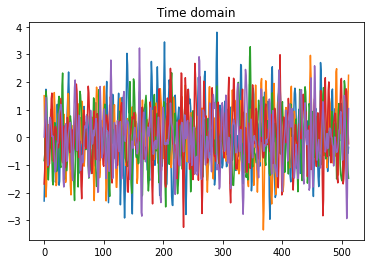

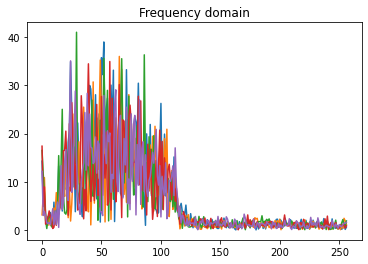

In [8]:
for i in range(5):
    plt.plot(data[i])
plt.title("Time domain")
plt.show()

for i in range(5):
    plt.plot(abs(fft.time2freq(data[i], 3.2*units.GHz)))
plt.title("Frequency domain")
plt.show()


In [9]:
# Create arrays for generator and critic loss
generator_loss = []
critic_loss = []

In [10]:
# Keras throws an error when calculating a loss without having a label -> needed for using the gradient penalty loss
positive_y = np.ones(wgan.batch_size)
negative_y = -positive_y
dummy = np.zeros(wgan.batch_size) 


In [13]:
# Training parameters
EPOCHS = 50
nsamples = len(data)
critic_iterations = 5
iterations_per_epoch = nsamples*2//(wgan.batch_size*critic_iterations)
iters = 0

Epoch:  0


2022-09-19 09:48:28.861347: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 09:48:29.126606: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


Iteration 1
Critic loss: [0.3356167, -0.5880555, 0.655407, 0.2682652]
Generator loss: 0.5979587


/afs/ifh.de/group/radio/software/anaconda_p3/envs/jupyter/lib/python3.9/site-packages/keras/engine/training_v1.py:2356: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


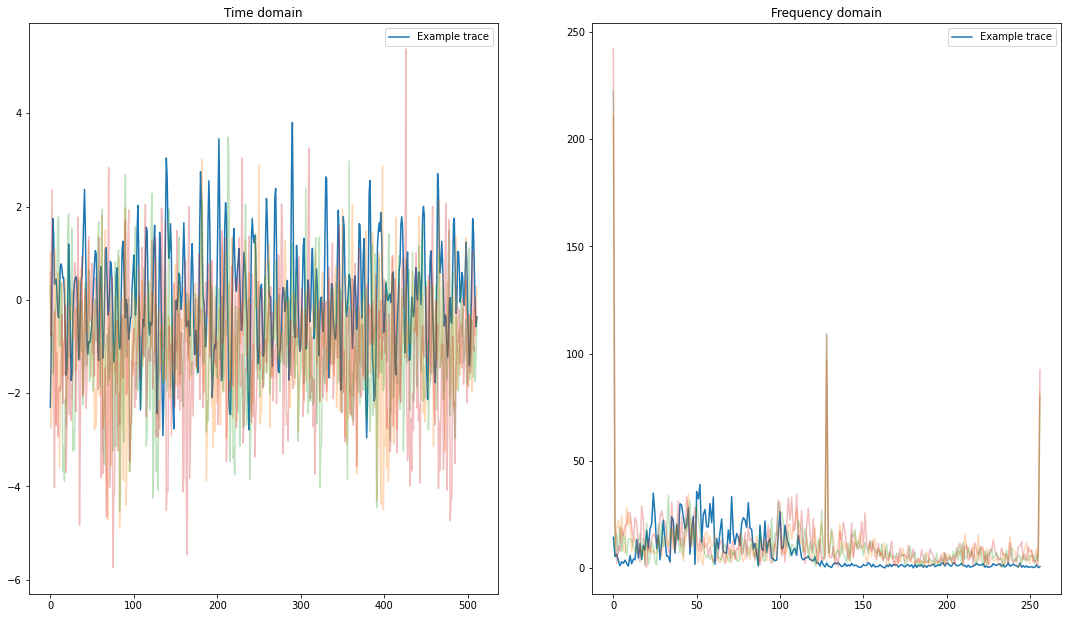

Epoch:  1
Epoch:  2
Epoch:  3
Epoch:  4
Epoch:  5
Iteration 301
Critic loss: [-0.389775, -0.80986065, 0.20067646, 0.2194092]
Generator loss: 0.8177805


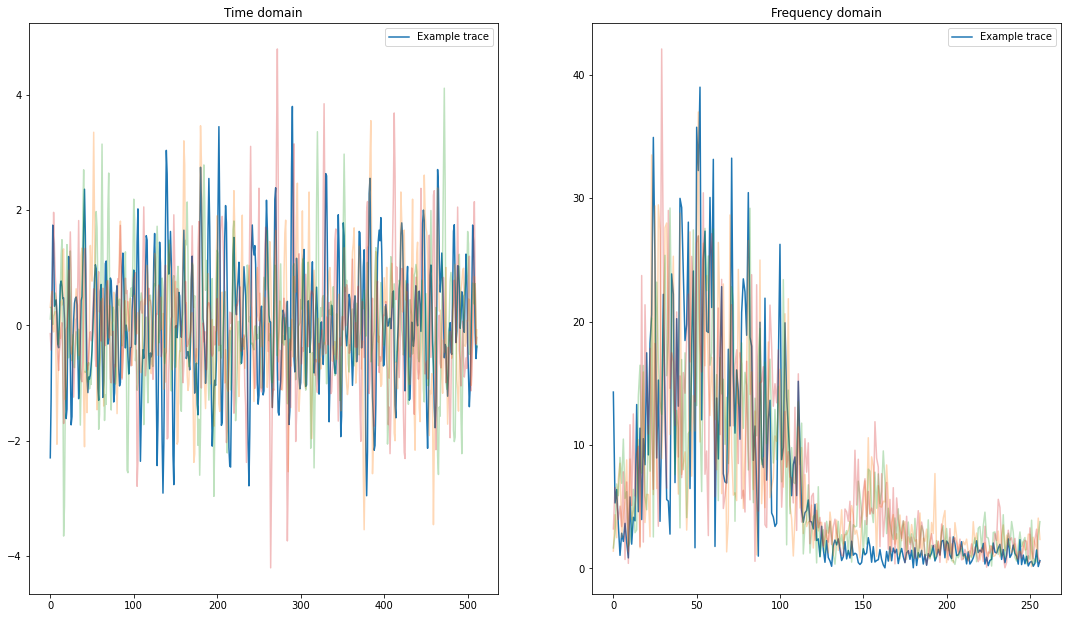

Epoch:  6
Epoch:  7


In [ ]:

for epoch in range(EPOCHS):
    
    print("Epoch: ", epoch)

    for iteration in range(iterations_per_epoch):
       
        for j in range(critic_iterations):
            
            # Pick data in batches 
            bunch=data[wgan.batch_size*(j+iteration):wgan.batch_size*(j++iteration+1)]
            bunch = np.expand_dims(bunch, axis=-1)  

            # Generate noise
            noise_batch = np.random.randn(wgan.batch_size, wgan.latent_size)
            noise_batch = np.expand_dims(noise_batch, axis=-1) 

            
            # Train critic
            critic_loss.append(wgan.critic_training.train_on_batch([noise_batch, bunch], [negative_y, positive_y, dummy]))
        

        # Generate noise batch for generator
        noise_batch = np.random.randn(wgan.batch_size, wgan.latent_size)
        noise_batch = np.expand_dims(noise_batch, axis=-1) 
        
        # Train the generator
        generator_loss.append(wgan.generator_training.train_on_batch([noise_batch], [positive_y]))  
        iters+=1
        
        # Printing losses and plotting example traces
        if iters % 300 == 1:
            print("Iteration", iters)
            print("Critic loss:", critic_loss[-1])
            print("Generator loss:", generator_loss[-1])
            
            # Generate signals
            noise = np.random.randn(wgan.batch_size, wgan.latent_size)
            noise = np.expand_dims(noise, axis=-1) 
            generated_signals = wgan.generator.predict_on_batch(noise)
            generated_signals = generated_signals[:,:,0]
            
            
            # Plot data
            
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.set_size_inches(18.5, 10.5, forward=True)
            ax1.title.set_text('Time domain')
            ax2.title.set_text('Frequency domain')
            
            

            ax1.plot(data[0], label = "Example trace")
#             plt.plot(np.random.randn(trace_length), label = 'Random noise')
            for i in range(3):
                ax1.plot(generated_signals[i], alpha=0.3)
            
            
            # Plot frequency
            ax2.plot(abs(fft.time2freq(data[0], 3.2*units.GHz)), label = "Example trace")
            for i in range(3):
                ax2.plot(abs(fft.time2freq(generated_signals[i], 3.2*units.GHz)),alpha=0.3)
                
            ax1.legend()
            ax2.legend()
            plt.show()


# Analyze results

In [54]:
noise = np.random.randn(len(data), wgan.latent_size)
noise = np.expand_dims(noise, axis=-1) 
generated_signals = wgan.generator.predict_on_batch(noise)
generated_signals = generated_signals[:,:,0]

In [55]:
analyze.metrics(data, generated_signals)

Mean generated: 0.00481574609875679
Mean data: 4.733117595886164e-18

Std generated: 1.0385167598724365
Std data: 1.0



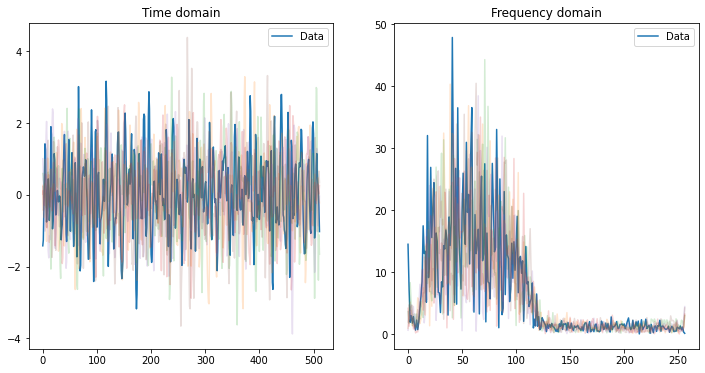

In [56]:
analyze.plot_traces(data, generated_signals, 5)

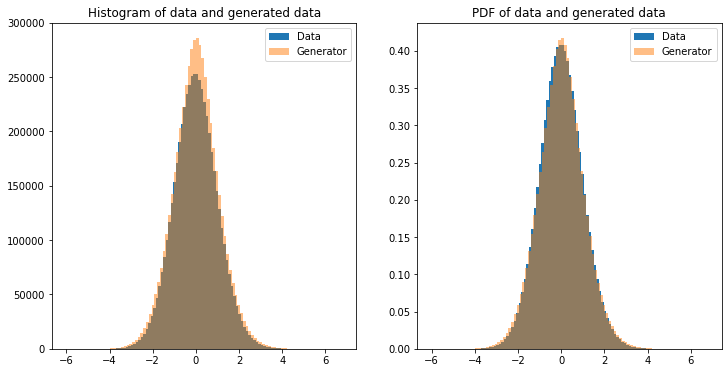

In [57]:
analyze.plot_histograms_time(data, generated_signals)


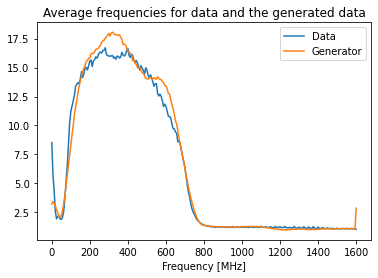

In [58]:
analyze.avg_frequencies(data, generated_signals)

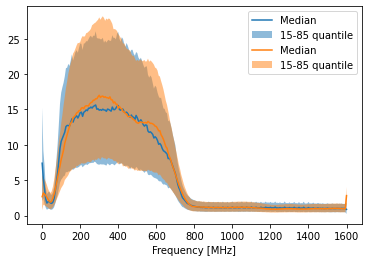

In [59]:
analyze.quantile_frequencies(data, generated_signals)

In [ ]:
# # Save the models
# g.save('generator')
# critic.save('critic')

In [35]:
# wgan.generator.save("time_fft_wavelet_generator")

INFO:tensorflow:Assets written to: time_fft_wavelet_generator/assets


INFO:tensorflow:Assets written to: time_fft_wavelet_generator/assets


In [36]:
print(type(wgan.generator))

<class 'keras.engine.functional.Functional'>
